# Image Selection (aka Masking)

Examples of mask usage

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from astroviper.image.selection import select_mask, apply_select

In [2]:
rng = np.random.default_rng(42)
ny, nx = 128, 160
y, x = np.mgrid[0:ny, 0:nx]
img = 0.1 + np.exp(-((x - nx / 2) ** 2) / (2 * 12.0 ** 2) - ((y - ny / 2) ** 2) / (2 * 8.0 ** 2))
# img = img + 0.05 * rng.normal(size=img.shape)
da = xr.DataArray(img, dims=("y", "x"), coords={"y": np.arange(ny), "x": np.arange(nx)}, name="intensity")

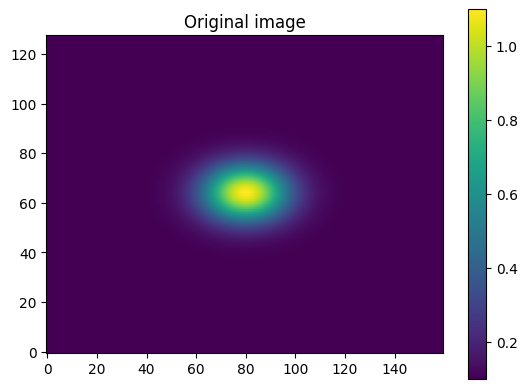

In [3]:
fig, ax = plt.subplots()
im = ax.imshow(da, origin="lower")
ax.set_title("Original image")
fig.colorbar(im, ax=ax)
plt.show()

## 1) `select=None` → use everything

mask_all dtype: bool true count: 20480


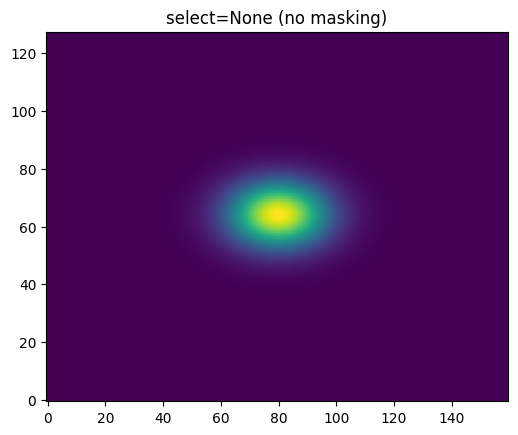

In [4]:
# creates an all True (nothing masked) selection/mask
mask_all = select_mask(da, select=None)
# apply that selection, everything is selected
sel_all = apply_select(da, select=None)

print("mask_all dtype:", mask_all.dtype, "true count:", int(mask_all.values.sum()))

fig, ax = plt.subplots()
ax.imshow(sel_all, origin="lower")
ax.set_title("select=None (no masking)")
plt.show()


## 2) Boolean array-like (DataArray or ndarray)
Create a circular region of interest (ROI) mask and apply it.

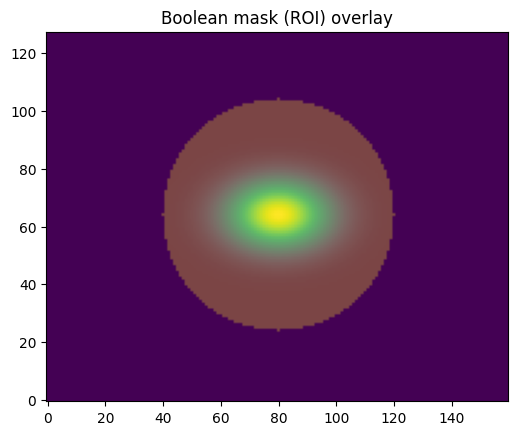

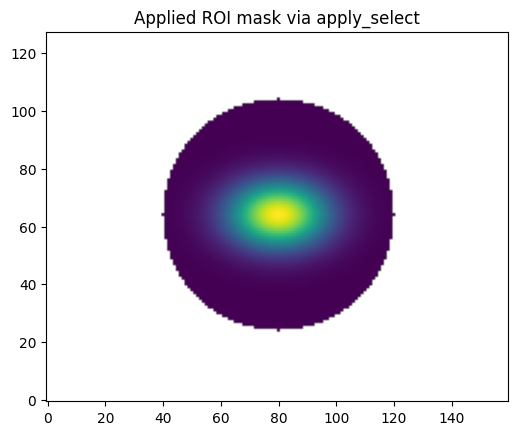

In [5]:
cy, cx = ny / 2, nx / 2
r = min(ny, nx) / 3.2  # why: focus on core region
roi = ((y - cy) ** 2 + (x - cx) ** 2) <= (r ** 2)
roi_da = xr.DataArray(roi, dims=("y", "x"), coords=da.coords, name="roi")

mask_roi = select_mask(da, select=roi_da)
sel_roi = apply_select(da, select=roi_da)

fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(mask_roi, origin="lower", alpha=0.3)
ax.set_title("Boolean mask (ROI) overlay")
plt.show()

fig, ax = plt.subplots()
ax.imshow(sel_roi, origin="lower")
ax.set_title("Applied ROI mask via apply_select")
plt.show()

## 3) String expression over named masks ("roi & ~bad & ~sidelobe")
Build masks and a `mask_source` mapping and use an expression.

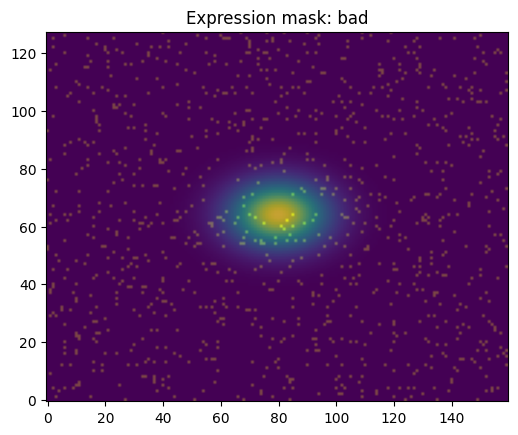

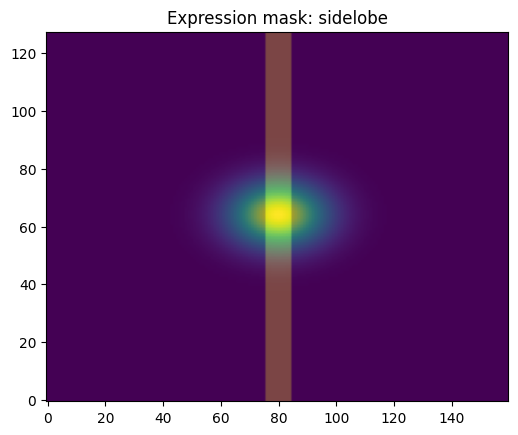

expr true count: 4095 of 20480


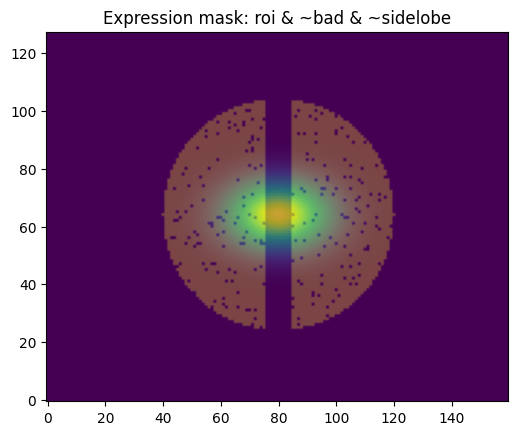

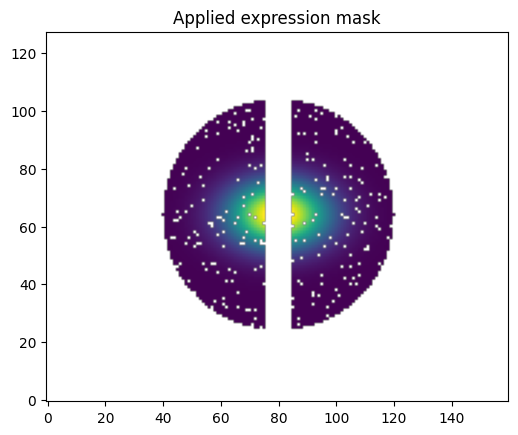

In [6]:
# bad: random speckles; sidelobe: thin frame near edges (why: emulate flagged pixels)

bad = rng.random((ny, nx)) < 0.05

expr = "bad"
fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(bad, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()


# sidelobe = (x < 5) | (x > nx - 6) | (y < 5) | (y > ny - 6)

sidelobe = (x > nx/2 - 5) & (x < nx/2 +5) 

expr = "sidelobe"
fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(sidelobe, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()


mask_source = {
    "roi": roi_da,                                 # keep xarray to preserve coords
    "bad": xr.DataArray(bad, dims=("y", "x"), coords=da.coords),
    "sidelobe": xr.DataArray(sidelobe, dims=("y", "x"), coords=da.coords),
}

"""
expr = "bad"
fig, ax = plt.subplots()
ax.imshow(mask_source["bad"], origin="lower")
ax.imshow(mask_expr, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()
"""


expr = "roi & ~bad & ~sidelobe"
# expr = "roi & ~sidelobe"

mask_expr = select_mask(da, select=expr, mask_source=mask_source)
sel_expr = apply_select(da, select=expr, mask_source=mask_source)

print(
    "expr true count:", int(mask_expr.values.sum()),
    "of", mask_expr.size,
)

fig, ax = plt.subplots()
ax.imshow(da, origin="lower")
ax.imshow(mask_expr, origin="lower", alpha=0.3)
ax.set_title(f"Expression mask: {expr}")
plt.show()

fig, ax = plt.subplots()
ax.imshow(sel_expr, origin="lower")
ax.set_title("Applied expression mask")
plt.show()
